In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from xgboost import XGBClassifier, plot_importance

# Szybki wgląd w dane

In [3]:
DATA_PATH = "Datasets/HCMST 2017 fresh sample for public sharing draft v1.1.dta"

In [4]:
df = pd.read_stata(DATA_PATH)

`Objaśniana zmienna jest zlokalizowana w kolumnie o etykiecie "S1".`

In [5]:
df["S1"].head()

0    No, I am not Married
1       Yes, I am Married
2       Yes, I am Married
3    No, I am not Married
4       Yes, I am Married
Name: S1, dtype: category
Categories (2, object): [Yes, I am Married < No, I am not Married]

In [6]:
df["S1"].isna().sum()

0

`Mogę się nią na razie nie przejmować przy redukcji cech`

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3510 entries, 0 to 3509
Columns: 285 entries, CaseID to subject_yrsed
dtypes: category(243), float32(20), float64(18), int16(2), int32(1), int8(1)
memory usage: 1.7 MB


In [8]:
df.head()

,CaseID,CASEID_NEW,qflag,weight1,weight1_freqwt,weight2,weight1a,weight1a_freqwt,weight_combo,weight_combo_freqwt,...,hcm2017q24_met_through_family,hcm2017q24_met_through_friend,hcm2017q24_met_through_as_nghbrs,hcm2017q24_met_as_through_cowork,w6_subject_race,interracial_5cat,partner_mother_yrsed,subject_mother_yrsed,partner_yrsed,subject_yrsed
0,2,2014039,Qualified,NaN,NaN,0.8945,NaN,NaN,0.277188,19240.0,...,no,no,no,no,White,no,12.0,14.0,12.0,14.0
1,3,2019003,Qualified,0.9078,71115.0,NaN,0.9026,70707.0,1.020621,70841.0,...,no,no,no,yes,White,no,12.0,16.0,17.0,17.0
2,5,2145527,Qualified,0.7205,56442.0,NaN,0.7164,56121.0,0.810074,56227.0,...,no,no,no,no,White,no,9.0,7.5,14.0,17.0
3,6,2648857,Qualified,1.2597,98682.0,1.3507,1.2524,98110.0,0.418556,29052.0,...,no,no,no,no,White,no,16.0,12.0,12.0,12.0
4,7,2623465,Qualified,0.8686,68044.0,NaN,0.8636,67652.0,0.976522,67781.0,...,no,no,yes,no,White,no,14.0,17.0,16.0,16.0


# Zmniejszenie zakresu kolumn

In [9]:
# Usunięcie kolumn rozciągłych, o nielicznym zbiorze wartosci
false_float_mask = (df.select_dtypes(include=["float32", "float64"]).apply(lambda x: pd.unique(x).shape[0]) < 25)
false_float_labels = false_float_mask[false_float_mask].index.values
df.drop(columns=false_float_labels, inplace=True)

In [10]:
# Usunięcie podejrzanie szerokich taksonomii
false_category_mask = df.select_dtypes(include=["category"]).apply(lambda x: pd.unique(x).shape[0]) > 10
false_category_labels = false_category_mask[false_category_mask].index.values
df.drop(columns=false_category_labels, inplace=True)

In [11]:
# Tworzenie maski logicznej wykluczającej kolumny majace wiecej niz 20% NaN-ów
nan_nb = df.isna().sum()
informative_columns_mask = (nan_nb < df.shape[0]/5).values

In [12]:
# Wyklucznie kolumn, pozbycie sie NaN-ów
df_masked = df.iloc[:,informative_columns_mask]
df_dropped = df_masked.dropna()
df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 1 to 3453
Columns: 165 entries, CaseID to interracial_5cat
dtypes: category(143), float32(11), float64(7), int16(2), int32(1), int8(1)
memory usage: 617.9 KB


# Rozdzielenie danych

In [13]:
df_y = df_dropped["S1"]
df_y.head()

1    Yes, I am Married
2    Yes, I am Married
4    Yes, I am Married
5    Yes, I am Married
6    Yes, I am Married
Name: S1, dtype: category
Categories (2, object): [Yes, I am Married < No, I am not Married]

In [14]:
target_unique_values = df_y.unique()
df_y = (df_y == "Yes, I am Married").astype(int)
df_y.value_counts()

1    1801
0     555
Name: S1, dtype: int64

In [15]:
df_X = df_dropped.drop(columns=["S1"], axis=1)

# Losowanie kolumn

In [16]:
def get_labels(df, dtype, threshold):
    cols = np.random.choice(df.select_dtypes(include=dtype).columns, 2, replace=False)
    if dtype[0] == "category":
        df[cols[0]] = pd.factorize(df[cols[0]])[0]
        df[cols[1]] = pd.factorize(df[cols[1]])[0]
    cond = abs(df[cols].corr().iloc[0,1]) < threshold
    return cols if cond else get_labels(df, dtype, threshold)

In [17]:
cat_feat = get_labels(df_X.copy(), ["category"], 0.5)

In [18]:
float_feat = get_labels(df_X.copy(), ["float32", "float64"], 0.5)

`Na szczęście bez zapętleń`

In [19]:
cat_feat

array(['hcm2017q24_met_online', 'race13'], dtype=object)

In [20]:
float_feat

array(['weight_combo_freqwt', 'w6_q16'], dtype=object)

# Informacje o kolumnach i encoding

## Po wylosowaniu 

In [21]:
target = ["S1"]
cat_feat = ['hcm2017q24_school', 'PPT612']
float_feat = ['w6_q21a_year', 'weight_combo_v2']
feat = cat_feat + float_feat + target

In [22]:
df = pd.read_stata(DATA_PATH)

In [23]:
df = df[feat]
df = df.dropna()
df_X = df[feat[:-1]]
df_y = df[target]

In [24]:
df_y = (df_y.S1 == "Yes, I am Married").astype(int)
df_y.value_counts()

1    2008
0    1245
Name: S1, dtype: int64

## Kategorialne

### Pierwsza

In [25]:
c0_col = df_X[cat_feat[0]]
c0_col.value_counts()

no     2899
yes     354
Name: hcm2017q24_school, dtype: int64

In [26]:
c0_col.head()

0    no
1    no
2    no
3    no
4    no
Name: hcm2017q24_school, dtype: category
Categories (2, object): [no < yes]

In [27]:
df_X[cat_feat[0]] =  pd.factorize(c0_col)[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


 ### Druga

In [28]:
c1_col = df_X[cat_feat[1]]
c1_col.value_counts()

0    2826
1     297
2      97
3      30
4       3
Name: PPT612, dtype: int64

In [29]:
c1_col.head()

0    0
1    0
2    2
3    0
4    0
Name: PPT612, dtype: category
Categories (5, int64): [0 < 1 < 2 < 3 < 4]

In [30]:
df_X[cat_feat[1]] =  pd.factorize(c1_col)[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## Ciągłe

### Pierwsza

In [31]:
f0_col = df_X[float_feat[0]]
f0_col.describe()

count    3253.000000
mean     1994.188441
std        17.118639
min      1939.000000
25%      1981.000000
50%      1998.000000
75%      2009.000000
max      2017.000000
Name: w6_q21a_year, dtype: float64

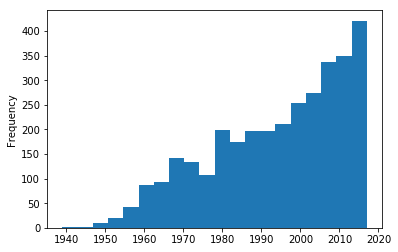

In [32]:
f0_col.plot('hist', bins=20)

### Druga

In [33]:
f1_col = df_X[float_feat[1]]
f1_col.describe()

count    3253.000000
mean        0.986094
std         0.405515
min         0.082981
25%         0.801292
50%         0.982432
75%         1.208193
max         3.400087
Name: weight_combo_v2, dtype: float64

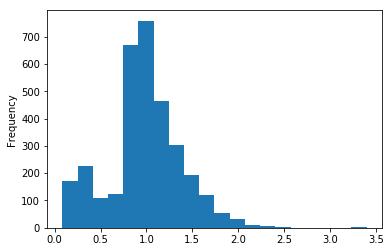

In [34]:
f1_col.plot('hist', bins=20)

# Budowanie modelu

In [35]:
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV

In [36]:
drawn_columns = np.concatenate([cat_feat, float_feat])

In [37]:
X = df_X[drawn_columns].values
y = df_y.values

In [38]:
fix_params = {'objective': 'binary:logistic', "seed": 42}
param_dist = {
    'n_estimators': stats.randint(150, 500),
    'learning_rate': np.linspace(0.01,0.1, 10),
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)],
    'max_depth': [3, 4, 5, 6, 7, 8, 9],
    'colsample_bytree': stats.uniform(0.5, 0.45),
    'min_child_weight':[1, 2, 4, 6, 8, 10, 12],
    'gamma':[i/10.0 for i in range(0,5)]
             }
clf = RandomizedSearchCV(estimator=XGBClassifier(**fix_params), param_distributions = param_dist, n_iter = 25, scoring = 'f1', cv=5, n_jobs = -1)
clf.fit(X,y)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=1),
          fit_params=None, iid='warn', n_iter=25, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f69e0a82a58>, 'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ]), 'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f69e0a82438>, 'max_depth': [3, 4, 5, 6, 7, 8, 9], 'min_child_weight': [1, 2, 4, 6, 8, 10, 12], 'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
          pre_dispatch='

In [39]:
best_params = {**clf.best_params_, **fix_params}
clf_xgb = XGBClassifier(**best_params)
clf_xgb.fit(X,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5788985113640754, gamma=0.3, learning_rate=0.01,
       max_delta_step=0, max_depth=3, min_child_weight=12, missing=None,
       n_estimators=278, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.9)

In [40]:
clf_xgb.feature_importances_

array([0.05386565, 0.12801014, 0.40874526, 0.40937895], dtype=float32)

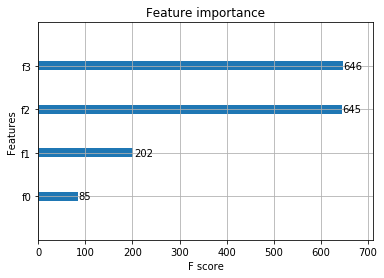

In [41]:
plot_importance(clf_xgb);

# Ceteris paribus

In [42]:
observation = X[42]

In [43]:
def cp_plot(model, feat_idx, observation_nb, deviate=50, point_nb=50):
    chosen_feature = X[:, feat_idx]
    observation = X[observation_nb]
    i_min = max(observation[feat_idx]-deviate, chosen_feature.min())
    i_max = min(observation[feat_idx]+deviate, chosen_feature.max())
    interval = np.linspace(i_min, i_max, point_nb)
    
    samples = np.repeat([observation], point_nb, axis=0)
    samples[:,feat_idx] = interval
    prob = model.predict_proba(samples)[:,1]
    observation_prob = model.predict_proba([observation])[:,1]
    
#     plt.figure(figsize=(10,10))
    plt.plot(interval, prob)
    plt.scatter(observation[feat_idx], observation_prob, s=100, c="r")
    plt.grid(linewidth=0.25)
    plt.axvline(x=observation[feat_idx], color="m", linewidth=0.5)
    plt.axhline(y=observation_prob, color="m", linewidth=0.5)
    plt.xlabel("feature: {}".format(float_feat[feat_idx%2]))
    plt.ylabel("marriage probability")

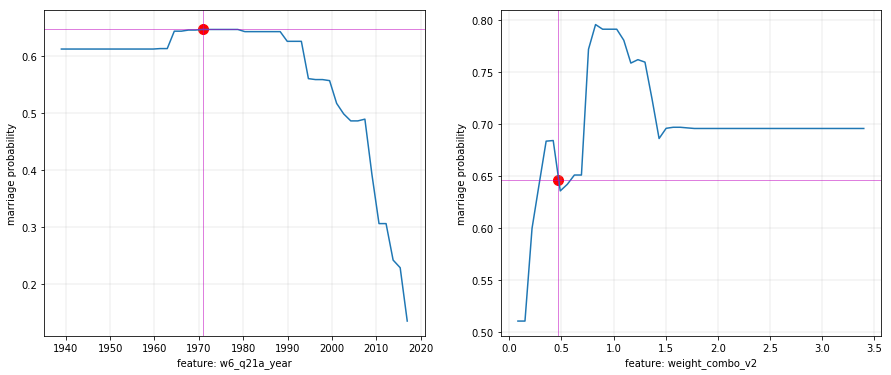

In [44]:
fig = plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
cp_plot(model=clf_xgb, feat_idx=2, observation_nb=42)

plt.subplot(1, 2, 2)
cp_plot(model=clf_xgb, feat_idx=3, observation_nb=42)

plt.show()

### Na podstawie tego losowania:

In [45]:
cat_feat

['hcm2017q24_school', 'PPT612']

In [46]:
float_feat

['w6_q21a_year', 'weight_combo_v2']

In [47]:
X[42]

array([0.00000000e+00, 0.00000000e+00, 1.97100000e+03, 4.71230835e-01])

Osoba na własnym utrzymaniu, zameldowana na północnym wschodzie, która:
> a) miała 17 lat gdy spotkała się ze swoją połówką, gdy spotkanie to było miedzy 1940, a 1990 rokiem, następnie to prawdomodobieństwo malało

> b) spotkala partnera w 1960 roku, miałaby największe szanse na zaślubiny, gdyby w tym roku była między 16 a 20 rokiem zycia, po tym okresie prawdopodobieństwo maleje.